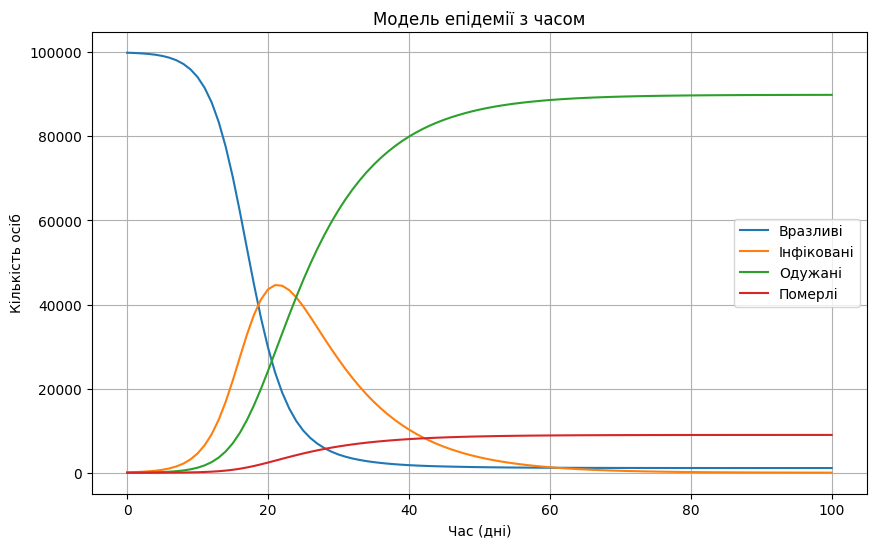

In [6]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Параметри моделі
N = 100000  # загальне населення
r = 5       # швидкість контакту на особу на день
c = 0.1     # ймовірність зараження за контакт
alpha = 1/10  # швидкість одужання на день
beta = 0.01   # швидкість смертності на день
u_max = 0     # немає щеплення/ізоляції

# Початкові умови
I0 = 100
S0 = N - I0
R0 = 0
D0 = 0
initial_conditions = [S0, I0, R0, D0]

# Інтервал часу
T = 100
t = np.linspace(0, T, T+1)  # 101 точка від 0 до 100

# Диференціальні рівняння
def model(t, y, N, r, c, alpha, beta, u_max):
    S, I, R, D = y
    dSdt = -r*c*I*S/N - u_max*S
    dIdt = r*c*I*S/N - alpha*I - beta*I
    dRdt = alpha*I
    dDdt = beta*I
    return [dSdt, dIdt, dRdt, dDdt]

# Розв'язання моделі
solution = solve_ivp(model, [0, T], initial_conditions, args=(N, r, c, alpha, beta, u_max), t_eval=t)

# Побудова графіка
plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], label='Вразливі')
plt.plot(solution.t, solution.y[1], label='Інфіковані')
plt.plot(solution.t, solution.y[2], label='Одужані')
plt.plot(solution.t, solution.y[3], label='Померлі')
plt.title('Модель епідемії з часом')
plt.xlabel('Час (дні)')
plt.ylabel('Кількість осіб')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
# Максимальна кількість інфікованих та час, коли це відбувається
I_max = np.max(solution.y[1])
t_max = solution.t[np.argmax(solution.y[1])]

I_max, t_max

(44630.99235498597, 21.0)

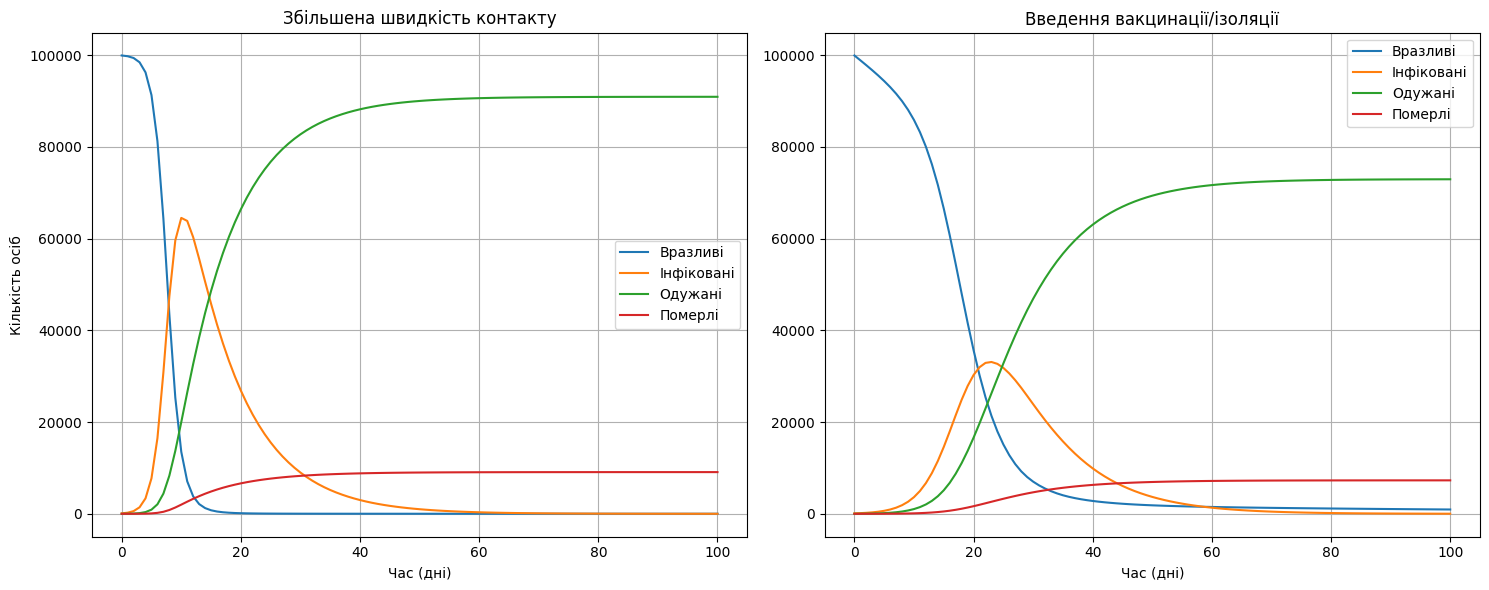

In [3]:
# Сценарій 1: збільшення швидкості контакту
r_increased = 10  # Збільшена швидкість контакту

# Розв'язання моделі зі збільшеною швидкістю контакту
solution_increased_r = solve_ivp(model, [0, T], initial_conditions, args=(N, r_increased, c, alpha, beta, u_max), t_eval=t)

# Сценарій 2: введення заходів (вакцинація/ізоляція)
u_max_vaccination = 0.01  # 1% вразливого населення щеплюється щодня

# Розв'язання моделі з вакцинацією
solution_vaccination = solve_ivp(model, [0, T], initial_conditions, args=(N, r, c, alpha, beta, u_max_vaccination), t_eval=t)

# Побудова обох сценаріїв
plt.figure(figsize=(15, 6))

# Збільшена швидкість контакту
plt.subplot(1, 2, 1)
plt.plot(solution_increased_r.t, solution_increased_r.y[0], label='Вразливі')
plt.plot(solution_increased_r.t, solution_increased_r.y[1], label='Інфіковані')
plt.plot(solution_increased_r.t, solution_increased_r.y[2], label='Одужані')
plt.plot(solution_increased_r.t, solution_increased_r.y[3], label='Померлі')
plt.title('Збільшена швидкість контакту')
plt.xlabel('Час (дні)')
plt.ylabel('Кількість осіб')
plt.legend()
plt.grid(True)

# Вакцинація
plt.subplot(1, 2, 2)
plt.plot(solution_vaccination.t, solution_vaccination.y[0], label='Вразливі')
plt.plot(solution_vaccination.t, solution_vaccination.y[1], label='Інфіковані')
plt.plot(solution_vaccination.t, solution_vaccination.y[2], label='Одужані')
plt.plot(solution_vaccination.t, solution_vaccination.y[3], label='Померлі')
plt.title('Введення вакцинації/ізоляції')
plt.xlabel('Час (дні)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
# Оцінка кінцевих результатів на основі останніх значень 

S_infinity = solution.y[0, -1]
I_infinity = solution.y[1, -1]
R_infinity = solution.y[2, -1]
D_infinity = solution.y[3, -1]

S_infinity, I_infinity, R_infinity, D_infinity

(1113.6710969928215, 20.171752425956328, 89878.32468234653, 8987.832468234656)

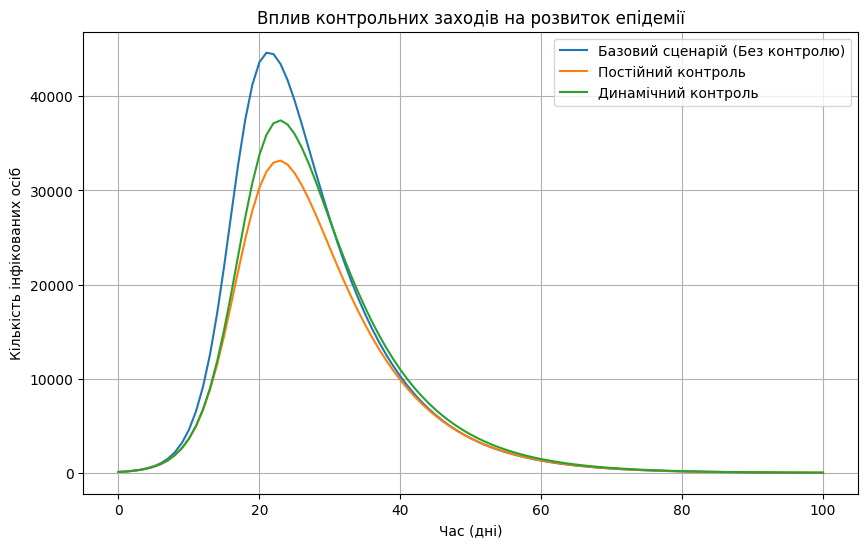

In [5]:
def model_with_control(t, y, N, r, c, alpha, beta, u_static, dynamic_control=False, I_threshold=0.05):
    S, I, R, D = y
    if dynamic_control and I/N > I_threshold:
        u = min(u_max, u_static * (I/N) / I_threshold)  # Динамічно збільшуємо u в залежності від інфекції
    else:
        u = u_static
    dSdt = -r*c*I*S/N - u*S
    dIdt = r*c*I*S/N - alpha*I - beta*I
    dRdt = alpha*I + u*S
    dDdt = beta*I
    return [dSdt, dIdt, dRdt, dDdt]

u_static = 0.01  # Постійний рівень вакцинації/ізоляції

solution_base = solve_ivp(model_with_control, [0, T], initial_conditions, args=(N, r, c, alpha, beta, 0, False), t_eval=t)
solution_static_control = solve_ivp(model_with_control, [0, T], initial_conditions, args=(N, r, c, alpha, beta, u_static, False), t_eval=t)
solution_dynamic_control = solve_ivp(model_with_control, [0, T], initial_conditions, args=(N, r, c, alpha, beta, u_static, True), t_eval=t)

# Візуалізація порівняння
plt.figure(figsize=(10, 6))
plt.plot(solution_base.t, solution_base.y[1], label='Базовий сценарій (Без контролю)')
plt.plot(solution_static_control.t, solution_static_control.y[1], label='Постійний контроль')
plt.plot(solution_dynamic_control.t, solution_dynamic_control.y[1], label='Динамічний контроль')
plt.title('Вплив контрольних заходів на розвиток епідемії')
plt.xlabel('Час (дні)')
plt.ylabel('Кількість інфікованих осіб')
plt.legend()
plt.grid(True)
plt.show()
